In [75]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import os
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from PIL import Image
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
from sklearn.model_selection import train_test_split
import cv2

In [76]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


### Adding images and converting to numpy array

In [77]:
directory = os.path.join('dataset','training_shuffle_400')

In [78]:
def read_pil_image(img_path, height, width):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((width, height)))

def load_all_images(dataset_path, height, width, img_ext='png'):
    return np.array([read_pil_image(str(p), height, width) for p in 
                                    Path(dataset_path).rglob("*."+img_ext)]) 

In [79]:
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=False,validation_split = .2)
test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=False)

In [80]:

x = load_all_images(os.path.join('dataset','small_train_sample'),64,64)

train_datagen.fit(x)
test_datagen.fit(x)

In [82]:
training_set = train_datagen.flow_from_directory(
    directory,target_size=(64, 64),batch_size=64,class_mode='categorical', shuffle = True,subset='training'
)

validation_set = train_datagen.flow_from_directory(directory,
                                        target_size=(64, 64),
                                                 batch_size=64,
                                      class_mode='categorical',
                                               shuffle = True,
                                           subset='validation')

test_set = test_datagen.flow_from_directory(os.path.join('dataset','test_random'),
                                                target_size=(64, 64),
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle = True)


Found 6190 images belonging to 24 classes.
Found 1536 images belonging to 24 classes.
Found 240 images belonging to 24 classes.


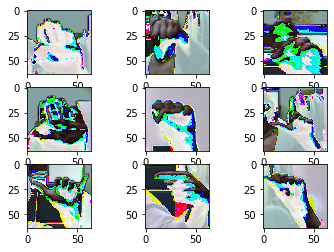

In [83]:
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = training_set.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image[0])
# show the figure
plt.show()

In [84]:
# Model architechture
model = Sequential()
# The first two layers with 32 filters of window size 3x3
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(24, activation='softmax'))

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 31, 31, 64)        18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 29, 29, 64)        36928     
                                                      

In [85]:
patience = 1
stop_patience = 4
factor = 0.5
checkpoint_path = "training_1_normalization/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1, restore_best_weights=True),
    # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
]


In [86]:
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6)
model.compile('adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [87]:
history = model.fit(training_set,epochs=30,validation_data = validation_set,verbose=1,callbacks=callbacks)

Epoch 1/30
97/97 [==============================] - ETA: 0s - loss: 3.3242 - accuracy: 0.1246
Epoch 00001: saving model to training_1_normalization\cp.ckpt
97/97 [==============================] - 6s 55ms/step - loss: 3.3242 - accuracy: 0.1246 - val_loss: 1.7361 - val_accuracy: 0.4889
Epoch 2/30
97/97 [==============================] - ETA: 0s - loss: 1.6427 - accuracy: 0.4792
Epoch 00002: saving model to training_1_normalization\cp.ckpt
97/97 [==============================] - 4s 41ms/step - loss: 1.6427 - accuracy: 0.4792 - val_loss: 1.0636 - val_accuracy: 0.6810
Epoch 3/30
97/97 [==============================] - ETA: 0s - loss: 1.0847 - accuracy: 0.6551
Epoch 00003: saving model to training_1_normalization\cp.ckpt
97/97 [==============================] - 5s 46ms/step - loss: 1.0847 - accuracy: 0.6551 - val_loss: 0.6924 - val_accuracy: 0.8047
Epoch 4/30
96/97 [============================>.] - ETA: 0s - loss: 0.7536 - accuracy: 0.7644
Epoch 00004: saving model to training_1_normaliz

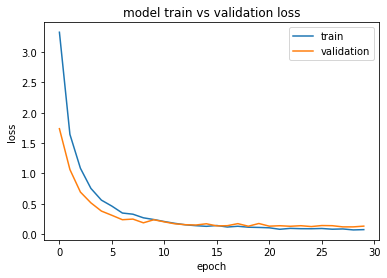

In [88]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

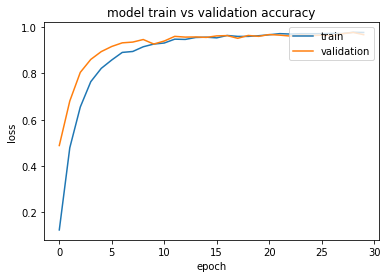

In [89]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [90]:
model.evaluate(test_set)

4/4 [==============================] - 0s 65ms/step - loss: 1.0537 - accuracy: 0.7917


[1.0537159442901611, 0.7916666865348816]

In [91]:
test_set.reset()
pred = model.predict(test_set)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_set.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

In [92]:
results.head(15)

,Filename,Predictions
0,a\Person_E_color_0_0003.png,x
1,a\Person_E_color_0_0030.png,s
2,a\Person_E_color_0_0078.png,y
3,a\Person_E_color_0_0145.png,k
4,a\Person_E_color_0_0202.png,x
5,a\Person_E_color_0_0276.png,i
6,a\Person_E_color_0_0277.png,u
7,a\Person_E_color_0_0431.png,g
8,a\Person_E_color_0_0467.png,v
9,a\Person_E_color_0_0471.png,s
